## basline CNN model 




In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# Project modules
from utils import *
from utils_visualisation import *
from Data_Handler import ClimbingDataset
from models import *
from engine import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassAccuracy
from torchinfo import summary


# Image filters
import kornia.filters as KF




/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameter:

blur_kernel_size = 5 
blur_sigma = 1.5
batch_size = 32
hidden_units_CNN = 16
hidden_units_classifier = 32
lr = 1e-4
weight_decay = 1e-4




In [3]:



transform = KF.GaussianBlur2d(kernel_size=(blur_kernel_size, blur_kernel_size), sigma=(blur_sigma, blur_sigma), border_type="constant")

climbing_DB = ClimbingDataset(board_names=["12 x 12 with kickboard Square"],#, "8 x 12 Home"],
                            map=True, 
                            transform=transform,
                            label_filter=[5, 14],
                            max_samples=12000 
)
num_classes = climbing_DB.num_classes
num_features = climbing_DB.num_features

print(num_classes, num_features)


/home/fillies/Documents/moon/kilter/data/boards.db /home/fillies/Documents/moon/kilter/data/static.db
21 4


In [4]:
print(len(climbing_DB))

X, y = climbing_DB[15]

print(X.shape, y.shape)



4472
torch.Size([4, 35, 35]) torch.Size([21])


In [5]:

train_size = int(0.8 * len(climbing_DB))  # 80% train
test_size = len(climbing_DB) - train_size

# Deterministic split (set generator seed for reproducibility)
train_dataset, test_dataset = random_split(
    climbing_DB,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")





Train samples: 3577, Test samples: 895


In [6]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
loss_fn = torch.nn.CrossEntropyLoss()
acc_fn = Multiclass_accuracy()# MulticlassAccuracy(num_classes=num_classes).to(device)





# Model with kernal size 3 an minimal classifyer
k3_model = CNN_K3(input_shape= num_features,
                     hidden_units_CNN= hidden_units_CNN, 
                     hidden_units_classifier=  hidden_units_classifier, 
                     output_shape=num_classes 
                     ).to(device)
optimizer_k3 = optim.Adam(k3_model.parameters(), lr=lr, weight_decay=weight_decay )


# Model with kernal size 5 an minimal classifyer
k5_model = CNN_K5(input_shape= num_features,
                     hidden_units_CNN= hidden_units_CNN, 
                     hidden_units_classifier=  hidden_units_classifier, 
                     output_shape=num_classes 
                     ).to(device)
optimizer_k5 = optim.Adam(k5_model.parameters(), lr=lr, weight_decay=weight_decay )

k7_model = CNN_K7(input_shape= num_features,
                     hidden_units_CNN= hidden_units_CNN, 
                     hidden_units_classifier=  hidden_units_classifier, 
                     output_shape=num_classes 
                     ).to(device)
optimizer_k7 = optim.Adam(k7_model.parameters(), lr=lr, weight_decay=weight_decay )


# Model with kernal size 3 an minimal classifyer
k9_model = CNN_K9(input_shape= num_features,
                     hidden_units_CNN= hidden_units_CNN, 
                     hidden_units_classifier=  hidden_units_classifier, 
                     output_shape=num_classes 
                     ).to(device)
optimizer_k9 = optim.Adam(k9_model.parameters(), lr=lr, weight_decay=weight_decay )

k11_model = CNN_K11(input_shape= num_features,
                     hidden_units_CNN= hidden_units_CNN, 
                     hidden_units_classifier=  hidden_units_classifier, 
                     output_shape=num_classes 
                     ).to(device)
optimizer_k11 = optim.Adam(k11_model.parameters(), lr=lr, weight_decay=weight_decay )


models = [k3_model, k5_model, k7_model, k9_model, k11_model]
optimizers = [ optimizer_k3, optimizer_k5, optimizer_k7, optimizer_k9,  optimizer_k11]





In [8]:
trained_models = {}
histories = {}

for model, optimizer in zip(models, optimizers):
    model_name = model.__class__.__name__
    print(f"\n🔹 Training {model_name}...")

    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        acc_fn=acc_fn,
        device=device,
        epochs=25,      # you can change this
        patience=5    # early stopping patience
    )

    trained_models[model_name] = trained_model
    histories[model_name] = history


🔹 Training CNN_K3...


/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 0000 | Train loss: 3.02755 | Train acc: 0.08696 | Test loss: 3.04954 | Test acc: 0.06938
Timing: total 2.059 s | train 1.695 s | eval 0.364 s

Epoch 0001 | Train loss: 2.96424 | Train acc: 0.26298 | Test loss: 2.91838 | Test acc: 0.33749
Timing: total 2.285 s | train 1.942 s | eval 0.343 s

Epoch 0002 | Train loss: 2.88641 | Train acc: 0.39671 | Test loss: 2.85661 | Test acc: 0.45258
Timing: total 1.707 s | train 1.339 s | eval 0.368 s

Epoch 0003 | Train loss: 2.81641 | Train acc: 0.49033 | Test loss: 2.77637 | Test acc: 0.53751
Timing: total 1.974 s | train 1.584 s | eval 0.390 s

Epoch 0004 | Train loss: 2.74509 | Train acc: 0.55713 | Test loss: 2.70595 | Test acc: 0.59562
Timing: total 1.967 s | train 1.609 s | eval 0.358 s

Epoch 0005 | Train loss: 2.68299 | Train acc: 0.59377 | Test loss: 2.62381 | Test acc: 0.65035
Timing: total 2.051 s | train 1.697 s | eval 0.355 s

Epoch 0006 | Train loss: 2.61862 | Train acc: 0.61867 | Test loss: 2.58204 | Test acc: 0.64253
Timing: to


📊 Distributions for CNN_K3:
True labels:
  Class 5: 379 (42.3%)
  Class 14: 516 (57.7%)

Predicted labels:
  Class 5: 217 (24.2%)
  Class 14: 678 (75.8%)

✅ Accuracy (overall): 72.74% (651/895)
ℹ️  Accuracy via acc_fn (avg over batches): 72.75%


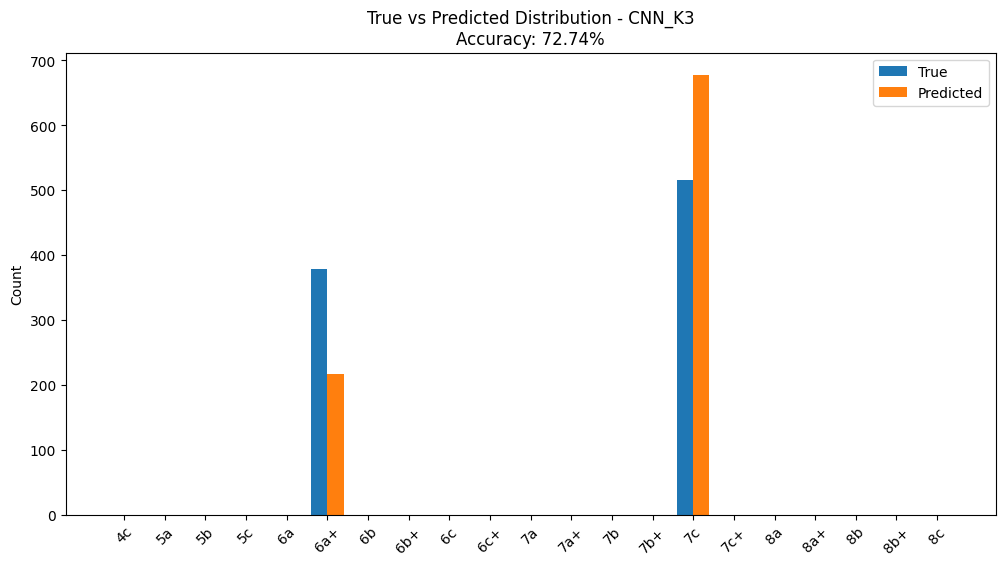

/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Distributions for CNN_K5:
True labels:
  Class 5: 379 (42.3%)
  Class 14: 516 (57.7%)

Predicted labels:
  Class 0: 9 (1.0%)
  Class 1: 1 (0.1%)
  Class 2: 8 (0.9%)
  Class 5: 49 (5.5%)
  Class 7: 3 (0.3%)
  Class 8: 6 (0.7%)
  Class 11: 1 (0.1%)
  Class 14: 806 (90.1%)
  Class 18: 6 (0.7%)
  Class 19: 4 (0.4%)
  Class 20: 2 (0.2%)

✅ Accuracy (overall): 62.57% (560/895)
ℹ️  Accuracy via acc_fn (avg over batches): 62.58%


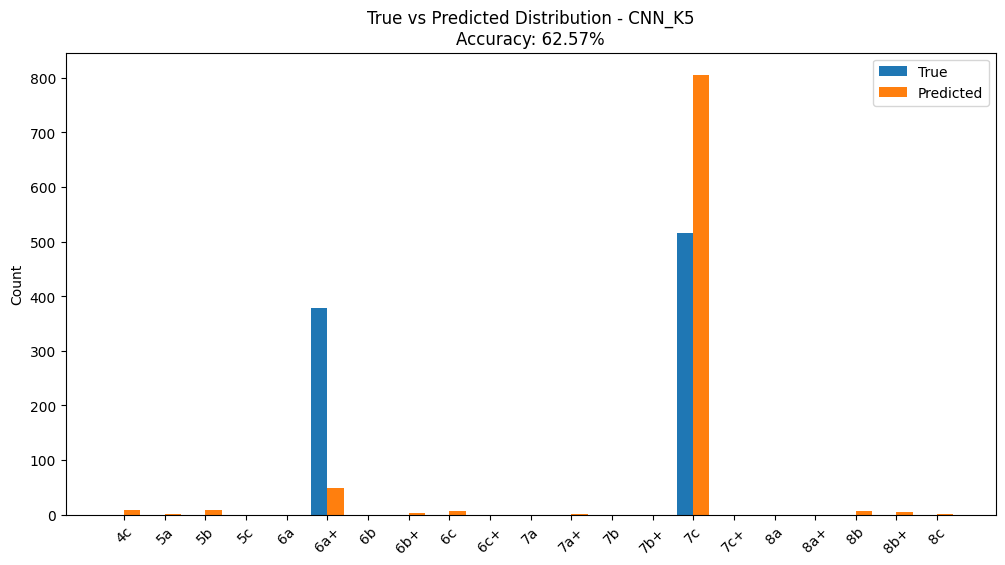

/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Distributions for CNN_K7:
True labels:
  Class 5: 379 (42.3%)
  Class 14: 516 (57.7%)

Predicted labels:
  Class 5: 356 (39.8%)
  Class 14: 539 (60.2%)

✅ Accuracy (overall): 85.14% (762/895)
ℹ️  Accuracy via acc_fn (avg over batches): 85.14%


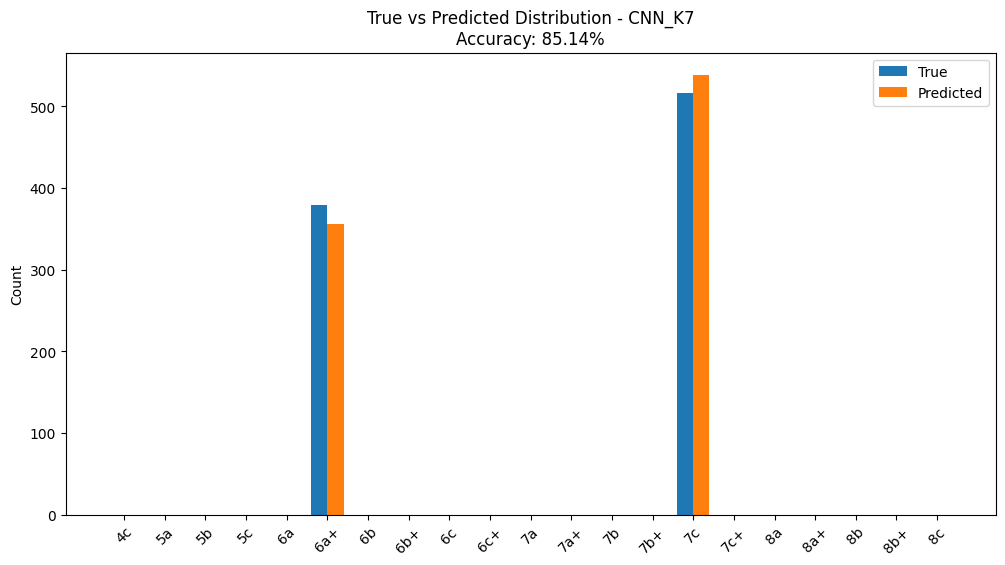

/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Distributions for CNN_K9:
True labels:
  Class 5: 379 (42.3%)
  Class 14: 516 (57.7%)

Predicted labels:
  Class 5: 350 (39.1%)
  Class 14: 545 (60.9%)

✅ Accuracy (overall): 87.15% (780/895)
ℹ️  Accuracy via acc_fn (avg over batches): 87.14%


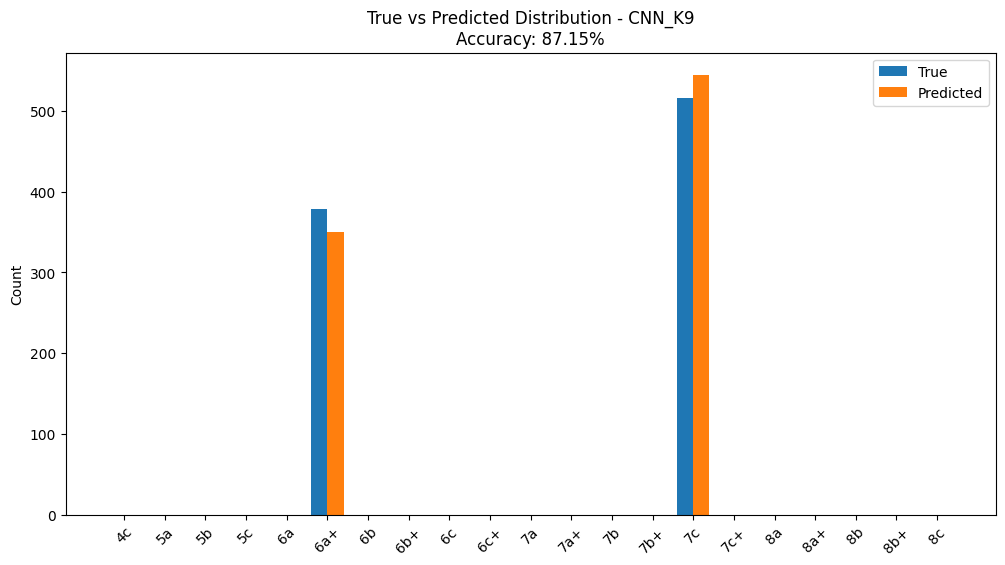

/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Distributions for CNN_K11:
True labels:
  Class 5: 379 (42.3%)
  Class 14: 516 (57.7%)

Predicted labels:
  Class 5: 361 (40.3%)
  Class 14: 534 (59.7%)

✅ Accuracy (overall): 87.04% (779/895)
ℹ️  Accuracy via acc_fn (avg over batches): 87.04%


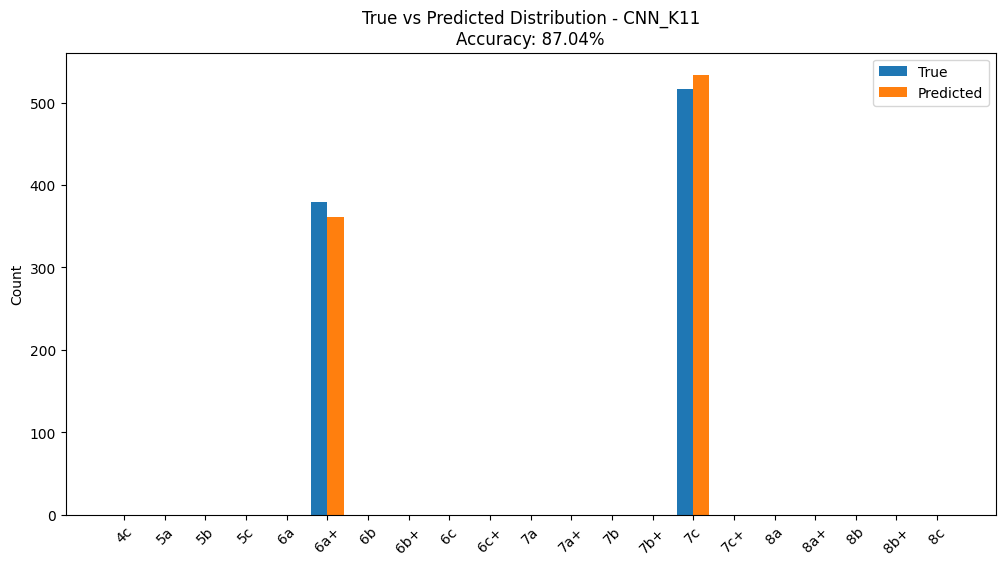

In [9]:

for each_model in models:
    plot_prediction_distribution(
        model=each_model,
        test_loader=test_loader,
        num_classes=num_classes,
        model_name=each_model.__class__.__name__,
        acc_fn=acc_fn,
        device=device
    )

In [10]:
best_model_name = max(histories, key=lambda k: max(histories[k]["test_acc"]))
print(f"🏆 Best performing model: {best_model_name}")

🏆 Best performing model: CNN_K11


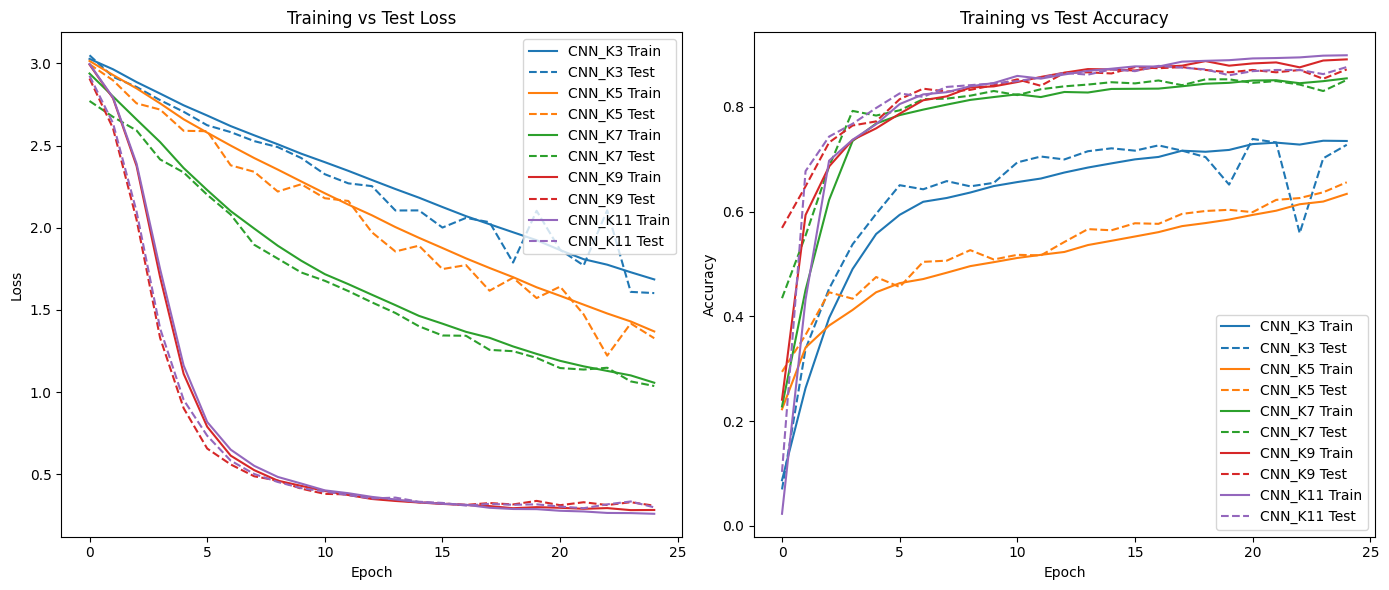

In [11]:
plot_training_histories(histories)